## Prerequisites:
1. Upload the dataset into the google drive.(link from the google sites page)
2. Clone the github repo

## Mounting to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries

In [2]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [3]:
import gc
import re
import os
import shutil
import math


import numpy as np
import scipy as sp
from tqdm import tqdm
import cv2

import tensorflow as tf
import keras
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model

from IPython.display import SVG
import efficientnet.tfkeras as efn

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

## Navigating to the root folder

In [5]:
os.getcwd()

'/content'

In [6]:
os.listdir()

['.config', 'drive', 'sample_data']

In [7]:
os.chdir('/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset')

In [8]:
os.getcwd()

'/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset'

In [9]:
os.listdir()

['test.csv',
 'train.csv',
 'images',
 'train_data.csv',
 'validation_data.csv',
 'test_data.csv',
 'old_data',
 'train_images',
 'valid_images',
 'test_images',
 'cnn.keras',
 'simple_CNN.png',
 'Leaf Classification.ipynb']

## Create validation and testing data

In [10]:
root_dir = os.getcwd()
root_dir

'/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset'

In [11]:
os.listdir(root_dir)

['test.csv',
 'train.csv',
 'images',
 'train_data.csv',
 'validation_data.csv',
 'test_data.csv',
 'old_data',
 'train_images',
 'valid_images',
 'test_images',
 'cnn.keras',
 'simple_CNN.png',
 'Leaf Classification.ipynb']

In [12]:
root_images_path = "/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/images"

root_csv_path = "/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train.csv"

## Run this part only once to generate the train, valid and test set

In [ ]:
# # Load the CSV file into a pandas DataFrame
# df = pd.read_csv(root_csv_path)

# # Split the data into training, validation, and testing sets
# train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% val, 15% test

# # Now you have three dataframes: train_df, val_df, and test_df

# # Example: Print the shapes of the resulting DataFrames
# print("Train data shape:", train_df.shape)
# print("Validation data shape:", val_df.shape)
# print("Test data shape:", test_df.shape)

# # You can further process these dataframes, such as saving them back to CSV files:
# train_df.to_csv("train_data.csv", index=False)
# val_df.to_csv("validation_data.csv", index=False)
# test_df.to_csv("test_data.csv", index=False)

Train data shape: (1274, 5)
Validation data shape: (273, 5)
Test data shape: (274, 5)


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train_data.csv")

In [ ]:
train_df

image_id  healthy  multiple_diseases  rust  scab
0      Train_710        1                  0     0     0
1     Train_1323        0                  0     0     1
2      Train_979        1                  0     0     0
3      Train_118        0                  0     1     0
4     Train_1144        0                  0     1     0
...          ...      ...                ...   ...   ...
1269  Train_1130        0                  0     0     1
1270  Train_1294        0                  0     0     1
1271   Train_860        0                  0     1     0
1272  Train_1459        1                  0     0     0
1273  Train_1126        0                  0     1     0

[1274 rows x 5 columns]

In [ ]:
val_df = pd.read_csv("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/validation_data.csv")

In [ ]:
val_df

image_id  healthy  multiple_diseases  rust  scab
0     Train_620        0                  0     1     0
1     Train_394        0                  0     1     0
2    Train_1492        0                  0     1     0
3     Train_481        0                  0     1     0
4    Train_1328        1                  0     0     0
..          ...      ...                ...   ...   ...
268   Train_932        0                  0     0     1
269  Train_1336        0                  0     0     1
270  Train_1096        0                  0     1     0
271   Train_893        1                  0     0     0
272   Train_485        0                  0     1     0

[273 rows x 5 columns]

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/test_data.csv")

In [ ]:
test_df

image_id  healthy  multiple_diseases  rust  scab
0    Train_1700        0                  0     0     1
1    Train_1313        1                  0     0     0
2     Train_432        1                  0     0     0
3    Train_1775        0                  0     1     0
4    Train_1708        0                  1     0     0
..          ...      ...                ...   ...   ...
269   Train_839        1                  0     0     0
270   Train_292        0                  0     0     1
271   Train_271        1                  0     0     0
272  Train_1519        0                  0     0     1
273  Train_1236        0                  1     0     0

[274 rows x 5 columns]

### Sort images into `training`, `validation` and `testing` set

In [ ]:
def create_directories(df, data_type):
    """Creates directories for each disease class within train/valid/test."""

    image_dir = os.path.join(root_dir, f"{data_type}_images")
    os.makedirs(image_dir, exist_ok=True)

    for disease in ['healthy', 'multiple_diseases', 'rust', 'scab']:
        disease_dir = os.path.join(image_dir, disease)
        os.makedirs(disease_dir, exist_ok=True)

In [ ]:
create_directories(train_df, "train")
create_directories(val_df, "valid")
create_directories(test_df, "test")

In [ ]:
def copy_images(df, source_dir, dest_dir):
  for index, row in df.iterrows():
    image_name = row['image_id'] + ".jpg"  # Assuming 'image' is the column name for image filenames
    source_path = os.path.join(source_dir, image_name)
    dest_path = os.path.join(dest_dir, image_name)

    if os.path.exists(source_path):
      shutil.copy2(source_path, dest_path) # copy2 preserves metadata
    else:
      print(f"Warning: Image not found - {source_path}")

In [ ]:
train_df

image_id  healthy  multiple_diseases  rust  scab
0      Train_710        1                  0     0     0
1     Train_1323        0                  0     0     1
2      Train_979        1                  0     0     0
3      Train_118        0                  0     1     0
4     Train_1144        0                  0     1     0
...          ...      ...                ...   ...   ...
1269  Train_1130        0                  0     0     1
1270  Train_1294        0                  0     0     1
1271   Train_860        0                  0     1     0
1272  Train_1459        1                  0     0     0
1273  Train_1126        0                  0     1     0

[1274 rows x 5 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1274 non-null   object
 1   healthy            1274 non-null   int64 
 2   multiple_diseases  1274 non-null   int64 
 3   rust               1274 non-null   int64 
 4   scab               1274 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 49.9+ KB


In [ ]:
# prompt: convert image_id into index

# Assuming 'image_id' is a column in your DataFrame
def image_id_to_index(image_id, df):
    """Converts an image_id to its corresponding index in the DataFrame."""
    try:
        index = df.index[df['image_id'] == image_id].tolist()[0]
        return index
    except IndexError:
        print(f"Error: Image ID '{image_id}' not found in the DataFrame.")
        return None

# Example usage:
# Assuming you have a DataFrame named 'train_df'
image_id = "Train_0"  # Replace with an actual image ID
index = image_id_to_index(image_id, train_df)
if index is not None:
    print(f"The index of image ID '{image_id}' is {index}")

In [ ]:
def sort_images(dataset, dest_dir):

    df = dataset.drop(["image_id"], axis = 1)
    print(df.columns)

    for index, data in dataset.iterrows():
        print(index)
        print(data)

        label = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)
        print(label)

        file_name = dataset["image_id"][index] + ".jpg"
        print("file_name", file_name)

        filepath = os.path.join(root_images_path, file_name)
        print("file_path:", file_path)

        destination = os.path.join(dest_dir, label, file_name)
        print("destination:", destination)

        shutil.copyfile(filepath, destination)

    for subdir in os.listdir(dest_dir):
        print(subdir, len(os.listdir(os.path.join(dest_dir, subdir))))

In [ ]:
sort_images(dataset = train_df,
            dest_dir = "/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train_images")

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')
0
image_id             Train_710
healthy                      1
multiple_diseases            0
rust                         0
scab                         0
Name: 0, dtype: object
0       healthy
1          scab
2       healthy
3          rust
4          rust
         ...   
1269       scab
1270       scab
1271       rust
1272    healthy
1273       rust
Length: 1274, dtype: object
file_name Train_710.jpg
file_path: Train_444.jpg


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'Series'

In [ ]:
def organize_images_by_disease(csv_path, image_dir, output_dir):
    """
    Organizes images into disease-specific directories based on argmax of disease columns.

    Parameters:
    - csv_path (str): Path to the CSV file containing image IDs and disease probabilities.
    - image_dir (str): Path to the directory containing images.
    - output_dir (str): Path to the directory where sorted images will be stored.

    Returns:
    - None
    """
    # Load the dataset
    df = pd.read_csv(csv_path)

    # Define disease categories
    categories = ['healthy', 'multiple_diseases', 'rust', 'scab']

    # Find the category with the highest value in each row
    df['disease'] = df[categories].idxmax(axis=1)

    # Create directories for each disease
    for category in categories:
        os.makedirs(os.path.join(output_dir, category), exist_ok=True)

    # Iterate through each row and move images
    for _, row in df.iterrows():
        image_name = row['image_id'] + ".jpg"  # Assuming images are in JPG format
        source_path = os.path.join(image_dir, image_name)
        target_path = os.path.join(output_dir, row['disease'], image_name)

        # Move or copy the image
        if os.path.exists(source_path):
            shutil.move(source_path, target_path)  # Use shutil.copy() to copy instead of move
        else:
            print(f"Image not found: {source_path}")

    print("Images have been organized successfully!")

In [ ]:
# Example Usage
organize_images_by_disease(
    csv_path="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train_data.csv",            # Path to the CSV file
    image_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/images",             # Path to the directory containing images
    output_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train_images"      # Path to the output directory
)


Images have been organized successfully!


In [ ]:
# Example Usage
organize_images_by_disease(
    csv_path="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/test_data.csv",            # Path to the CSV file
    image_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/images",             # Path to the directory containing images
    output_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/test_images"      # Path to the output directory
)


Images have been organized successfully!


In [ ]:
# Example Usage
organize_images_by_disease(
    csv_path="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/validation_data.csv",            # Path to the CSV file
    image_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/images",             # Path to the directory containing images
    output_dir="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/valid_images"      # Path to the output directory
)

Images have been organized successfully!


In [ ]:
print("Number of images in train_images:", len(os.listdir('train_images')))
print("Number of images in valid_images:", len(os.listdir('valid_images')))
print("Number of images in test_images:", len(os.listdir('test_images')))

Number of images in train_images: 1274
Number of images in valid_images: 273
Number of images in test_images: 274


## Data Description

In [ ]:
IMAGE_PATH = "images"

TEST_CSV_PATH = "test_data.csv"
TRAIN_CSV_PATH = "train_data.csv"
VALID_CSV_PATH = "validation_data.csv"

TRAIN_IMAGE_PATH = "train_images"
TEST_IMAGE_PATH = "test_images"
VALID_IMAGE_PATH = "valid_images"

In [ ]:
SAMPLE_LEN = 100

### Training Data

In [ ]:
train_data = pd.read_csv(TRAIN_CSV_PATH)

In [ ]:
train_data

image_id  healthy  multiple_diseases  rust  scab
0      Train_710        1                  0     0     0
1     Train_1323        0                  0     0     1
2      Train_979        1                  0     0     0
3      Train_118        0                  0     1     0
4     Train_1144        0                  0     1     0
...          ...      ...                ...   ...   ...
1269  Train_1130        0                  0     0     1
1270  Train_1294        0                  0     0     1
1271   Train_860        0                  0     1     0
1272  Train_1459        1                  0     0     0
1273  Train_1126        0                  0     1     0

[1274 rows x 5 columns]

In [ ]:
train_data.describe(include="all")

image_id      healthy  multiple_diseases         rust         scab
count        1274  1274.000000        1274.000000  1274.000000  1274.000000
unique       1274          NaN                NaN          NaN          NaN
top     Train_710          NaN                NaN          NaN          NaN
freq            1          NaN                NaN          NaN          NaN
mean          NaN     0.288854           0.048666     0.343014     0.319466
std           NaN     0.453408           0.215253     0.474903     0.466453
min           NaN     0.000000           0.000000     0.000000     0.000000
25%           NaN     0.000000           0.000000     0.000000     0.000000
50%           NaN     0.000000           0.000000     0.000000     0.000000
75%           NaN     1.000000           0.000000     1.000000     1.000000
max           NaN     1.000000           1.000000     1.000000     1.000000

In [ ]:
train_data.isnull().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

### Testing Data

In [ ]:
test_data = pd.read_csv(TEST_CSV_PATH)

In [ ]:
test_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_1700        0                  0     0     1
1  Train_1313        1                  0     0     0
2   Train_432        1                  0     0     0
3  Train_1775        0                  0     1     0
4  Train_1708        0                  1     0     0

In [ ]:
test_data.isnull().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

### Validation Data

In [ ]:
valid_data = pd.read_csv(VALID_CSV_PATH)

In [ ]:
valid_data.head()

image_id  healthy  multiple_diseases  rust  scab
0   Train_620        0                  0     1     0
1   Train_394        0                  0     1     0
2  Train_1492        0                  0     1     0
3   Train_481        0                  0     1     0
4  Train_1328        1                  0     0     0

In [ ]:
test_data.isnull().sum()

image_id             0
healthy              0
multiple_diseases    0
rust                 0
scab                 0
dtype: int64

## Load Images

In [ ]:
def load_image(image_id: str):
    '''
    Insert image_id from the training or testing dataset and it will load the image.
    '''
    file_path = image_id + ".jpg"
    image = cv2.imread(os.path.join(IMAGE_PATH, file_path))
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

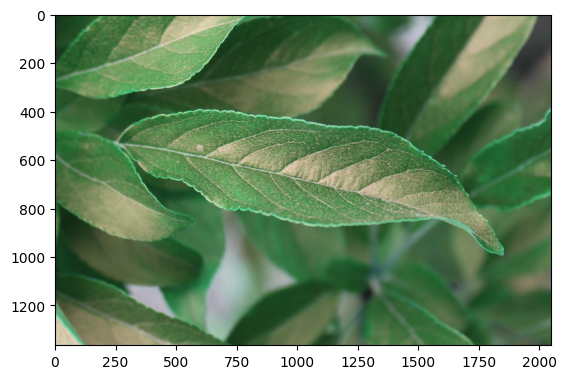

In [ ]:
file_path = "Train_444" + ".jpg"
# This loads the image in BGR channel, to get the actual image we nee to convert this into RGB channel
image = cv2.imread(os.path.join(TRAIN_IMAGE_PATH, file_path))

plt.imshow(image)

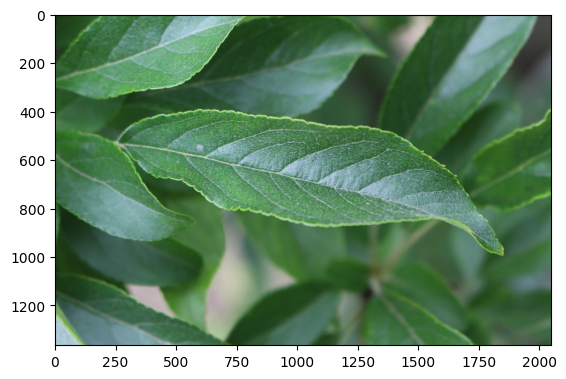

In [ ]:
image = cv2.imread(os.path.join(IMAGE_PATH, file_path))
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

### Key Differences

| Feature           | **RGB**                                   | **BGR**                                   |
|-------------------|-------------------------------------------|-------------------------------------------|
| **Channel Order** | Red, Green, Blue                          | Blue, Green, Red                          |
| **Default In**    | Matplotlib, PIL, displays, and web standards | OpenCV and some camera drivers            |
| **Conversion**    | Directly supports most modern devices     | Requires conversion for visualization in non-OpenCV tools |


Due to difference in the channel order, in which it is represented, The image looks bit different


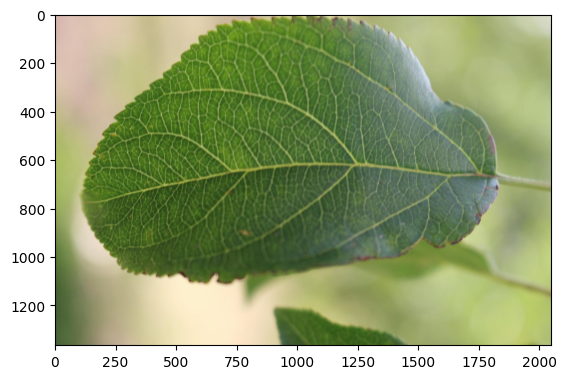

In [ ]:
load_image("Train_1818")

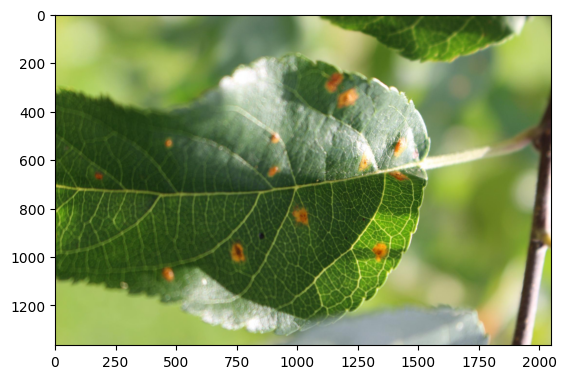

In [ ]:
load_image("Test_4")

100%|██████████| 100/100 [00:03<00:00, 25.68it/s]


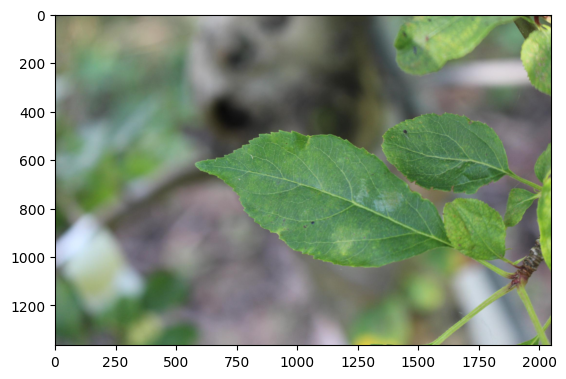

In [ ]:
train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

In [ ]:
sample_df = train_data[:SAMPLE_LEN]

In [ ]:
sample_df

image_id  healthy  multiple_diseases  rust  scab
0    Train_0        0                  0     0     1
1    Train_1        0                  1     0     0
2    Train_2        1                  0     0     0
3    Train_3        0                  0     1     0
4    Train_4        1                  0     0     0
..       ...      ...                ...   ...   ...
95  Train_95        0                  1     0     0
96  Train_96        0                  0     1     0
97  Train_97        0                  0     1     0
98  Train_98        0                  0     1     0
99  Train_99        1                  0     0     0

[100 rows x 5 columns]

In [ ]:
sample_df.value_counts()

image_id  healthy  multiple_diseases  rust  scab
Train_99  1        0                  0     0       1
Train_0   0        0                  0     1       1
Train_1   0        1                  0     0       1
Train_10  0        0                  1     0       1
Train_85  0        0                  0     1       1
                                                   ..
Train_15  0        0                  1     0       1
Train_16  0        0                  0     1       1
Train_17  0        0                  0     1       1
Train_18  1        0                  0     0       1
Train_19  0        0                  0     1       1
Name: count, Length: 100, dtype: int64

100%|██████████| 100/100 [00:02<00:00, 36.02it/s]


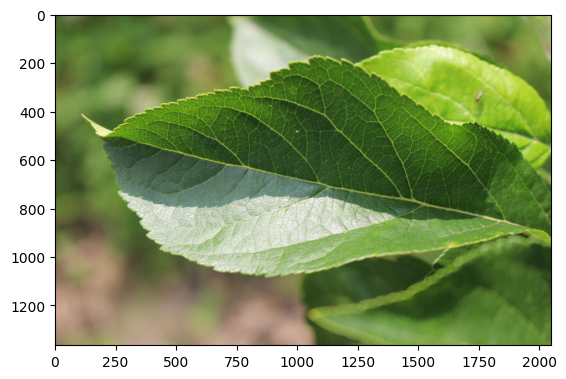

In [ ]:
train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

In [ ]:
def plot_class_distribution(df: pd.DataFrame):
    label_distribution = df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()

    # Visualize the distribution using a bar plot
    plt.figure(figsize=(8, 6))
    plt.bar(label_distribution.index, label_distribution.values)
    plt.title('Distribution of Target Labels')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

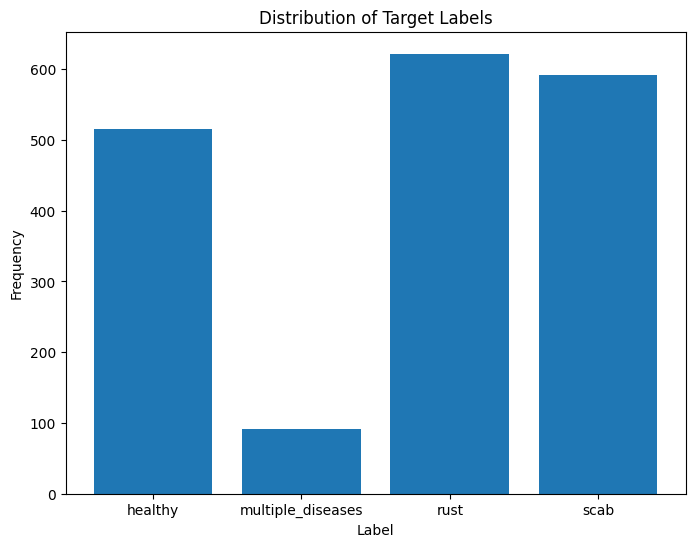

In [ ]:
plot_class_distribution(train_data)

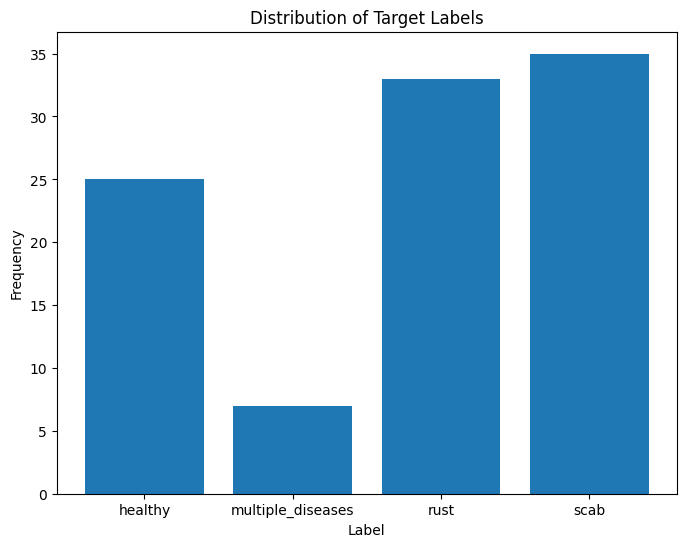

In [ ]:
plot_class_distribution(sample_df)

In [ ]:
sample_df

image_id  healthy  multiple_diseases  rust  scab
0    Train_0        0                  0     0     1
1    Train_1        0                  1     0     0
2    Train_2        1                  0     0     0
3    Train_3        0                  0     1     0
4    Train_4        1                  0     0     0
..       ...      ...                ...   ...   ...
95  Train_95        0                  1     0     0
96  Train_96        0                  0     1     0
97  Train_97        0                  0     1     0
98  Train_98        0                  0     1     0
99  Train_99        1                  0     0     0

[100 rows x 5 columns]

## Visualize sample leaves

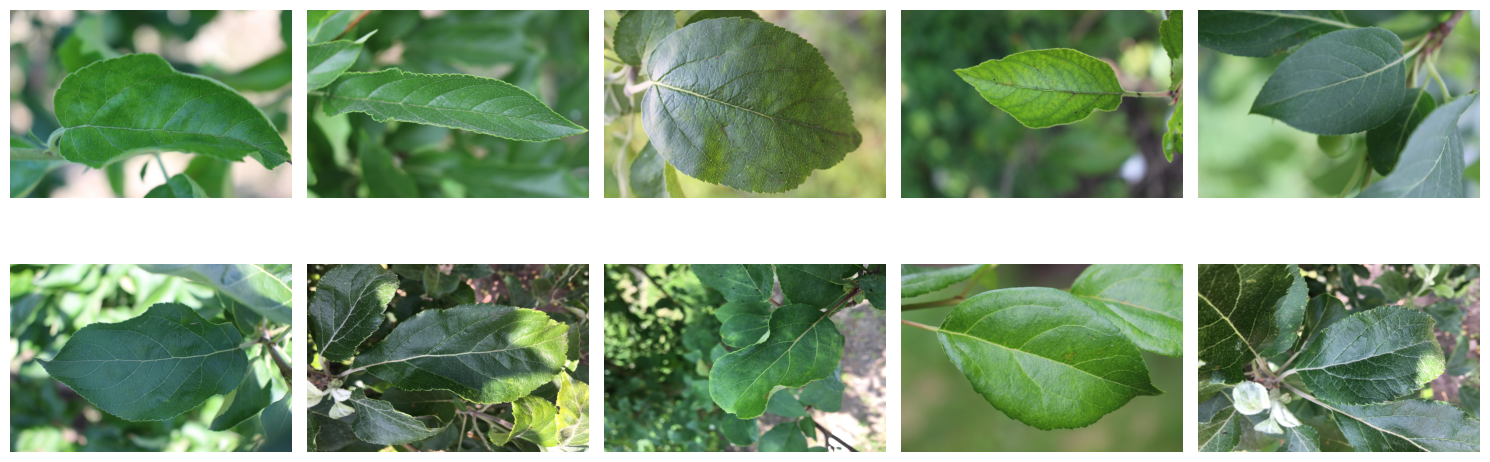

In [ ]:
# Assuming IMAGE_PATH is defined as in the provided code
IMAGE_PATH = "images"

def load_and_plot_images(image_ids, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust layout as needed
    axes = axes.ravel()  # Flatten the axes array

    for i, image_id in enumerate(image_ids[:num_images]):
        file_path = image_id + ".jpg"
        image = cv2.imread(os.path.join(IMAGE_PATH, file_path))
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].axis('off')  # Turn off axes for image display

    plt.tight_layout()
    plt.show()

# Example usage: Assuming you have a list of healthy image IDs in 'healthy_image_ids'
# Replace with actual IDs from your dataset where the 'healthy' label is 1.
healthy_image_ids = train_data[train_data["healthy"]==1]["image_id"].tolist()[:10]
load_and_plot_images(healthy_image_ids)

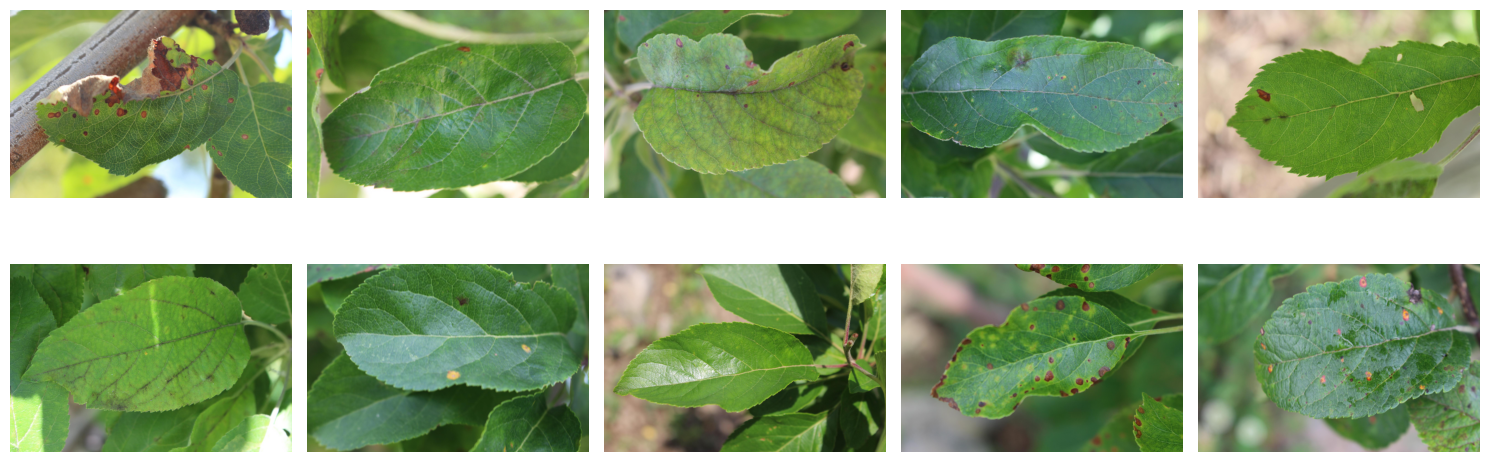

In [ ]:
healthy_image_ids = train_data[train_data["multiple_diseases"]==1]["image_id"].tolist()[:10]
load_and_plot_images(healthy_image_ids)

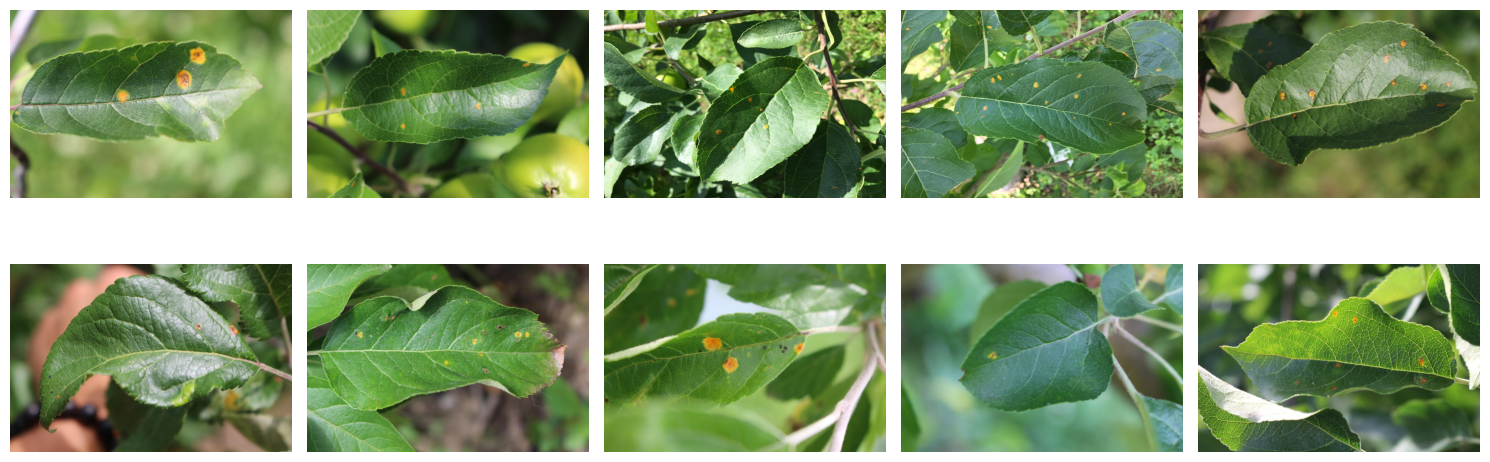

In [ ]:
# prompt: Plot 10 healthy leaves

# Assuming IMAGE_PATH is defined as in the provided code

# Example usage: Assuming you have a list of healthy image IDs in 'healthy_image_ids'
# Replace with actual IDs from your dataset where the 'healthy' label is 1.
rust_image_ids = train_data[train_data["rust"]==1]["image_id"].tolist()[:10]
load_and_plot_images(rust_image_ids)

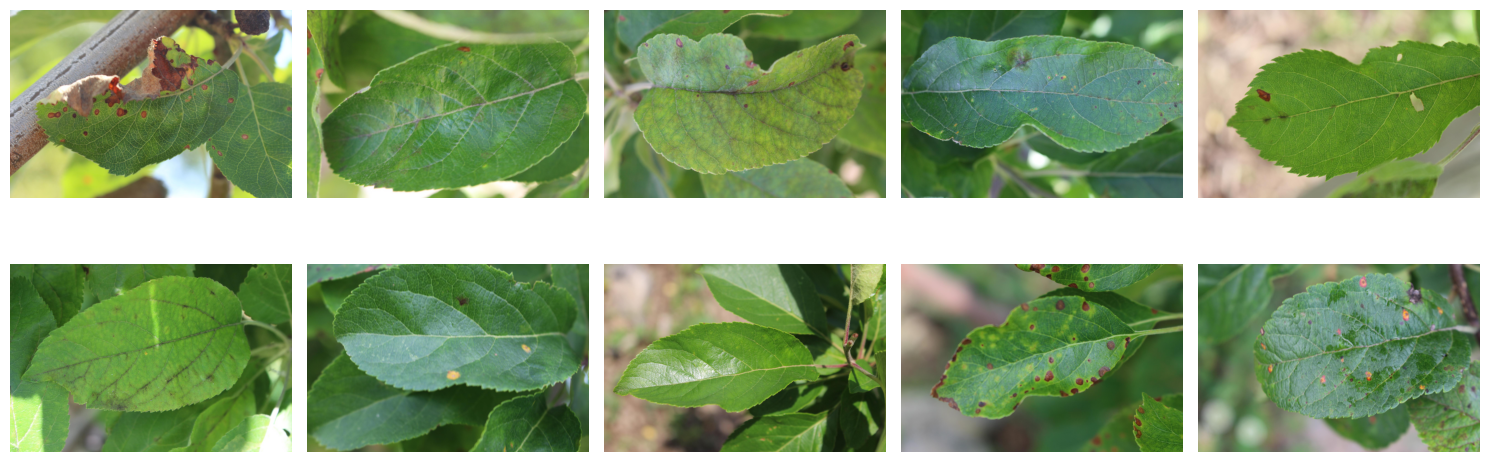

In [ ]:
scab_image_ids = train_data[train_data["scab"]==1]["image_id"].tolist()[:10]
load_and_plot_images(healthy_image_ids)

In [ ]:
fig = go.Figure([go.Pie(labels=train_data.columns[1:],
           values=train_data.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [ ]:
train_data["Healthy"] = train_data["healthy"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
train_data["Scab"] = train_data["scab"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
train_data["Rust"] = train_data["rust"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
train_data["Multiple diseases"] = train_data["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

## Architecture of a basic CNN model
![Typical CNN Architecture](https://vitalflux.com/wp-content/uploads/2022/04/Typical-CNN-architecture.png)


### What is convolution?

Convolution is an algorithm which involves a kernel (a 2D matrix) which moves over the entire image, calculating dot products with each window along the way. The GIF below demonstrates convolution in action.

<center><img src="https://i.imgur.com/wYUaqR3.gif" width="450px"></center>

The above process can be summarized with an equation, where *f* is the image and *h* is the kernel. The dimensions of *f* are *(m, n)* and the kernel is a square matrix with dimensions smaller than *f*:

<center><img src="https://i.imgur.com/9scTOGv.png" width="350px"></center>
<br>

In the above equation, the kernel *h* is moving across the length and breadth of the image. The dot product of *h* with a sub-matrix or window of matrix *f* is taken at each step, hence the double summation (rows and columns). Below I demonstrate the effect of convolution on leaf images.

In [ ]:
def conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel)
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Convolved Image', fontsize=24)
    plt.show()

In [ ]:
train_data

image_id  healthy  multiple_diseases  rust  scab Healthy   Scab  \
0        Train_0        0                  0     0     1   False   True   
1        Train_1        0                  1     0     0   False  False   
2        Train_2        1                  0     0     0    True  False   
3        Train_3        0                  0     1     0   False  False   
4        Train_4        1                  0     0     0    True  False   
...          ...      ...                ...   ...   ...     ...    ...   
1816  Train_1816        0                  0     0     1   False   True   
1817  Train_1817        1                  0     0     0    True  False   
1818  Train_1818        1                  0     0     0    True  False   
1819  Train_1819        0                  0     1     0   False  False   
1820  Train_1820        0                  0     0     1   False   True   

       Rust Multiple diseases  
0     False             False  
1     False              True  
2     False             False  
3      True             False  
4     False             False  
...     ...               ...  
1816  False             False  
1817  False             False  
1818  False             False  
1819   True             False  
1820  False             False  

[1821 rows x 9 columns]

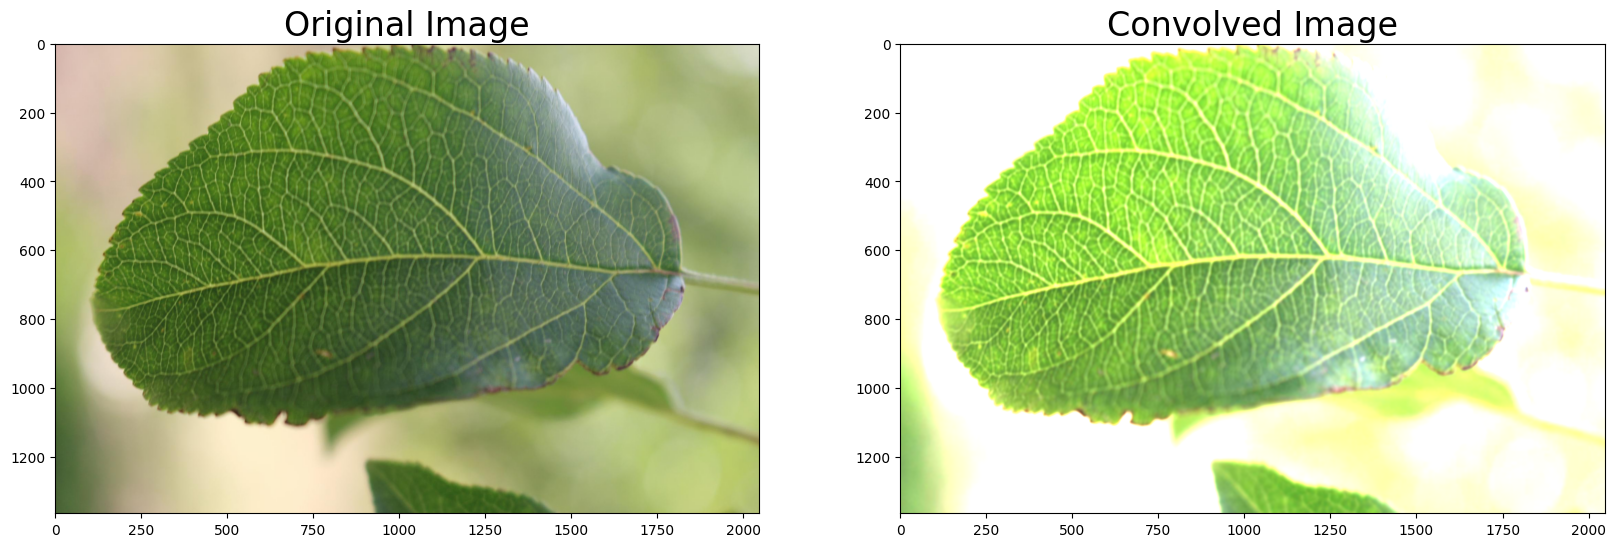

In [ ]:
# prompt: perform convolution operation on images

def conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel)
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Convolved Image', fontsize=24)
    plt.show()
# Example usage (assuming you have an image loaded as 'img'):
# Assuming 'img' is loaded using cv2.imread and then converted to RGB using cv2.cvtColor
#  as shown in the provided code.

# Example with a sample image (replace 'Train_1818.jpg' with an actual image path)
file_path = "Train_1818.jpg"
image = cv2.imread(os.path.join(IMAGE_PATH, file_path))
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
conv(img_rgb)

### What is MaxPool?

Max pooling is very similar to convolution, except it involves finding the maximum value in a window instead of finding the dot product of the window with a kernel. Max pooling does not require a kernel and it is very useful in reducing the dimensionality of convolutional feature maps in CNNs. The image below demonstrates the working of MaxPool:


<center><img src="https://i.imgur.com/rBNMsfi.png" width="400px"></center>
<br></br>

The above example demonstrates max pooling with a window size of *(2, 2)*. This process can be represented with the equation below:
<br></br>
.

<center><img src="https://i.imgur.com/FRyMNhI.png" width="650px"></center>
<br></br>

In the above equation, the window moves across the image and the maximum value in each winow is calculated. Once again, this process is very important in reducing the complexity of CNNs while retaining features.

### ReLU

ReLU is an activation function commonly used in neural network architectures. *ReLU(x)* returns 0 for *x < 0* and *x* otherwise. This function helps introducenon-linearity in the neural network, thus increasing its capacity ot model the image data. The graph and equation of *ReLU* are:

<center><img src="https://i.imgur.com/eiRVQBh.png" width="400px"></center>

<center><img src="https://i.imgur.com/0mBFAH0.png" width="400px"></center>
<br></br>

As mentioned earlier, this function is non-linear and helps increase the modeling capacity of the CNN models. Now since we understand the basic building blocks of pretrained images models, let us finetune some pretained ImageNet models on TPU and visualize the results!

In [ ]:
# prompt: find shape of "Train_1818.jpg"

import cv2
import os

IMAGE_PATH = "images"
file_path = "Train_1818.jpg"
image = cv2.imread(os.path.join(IMAGE_PATH, file_path))
image.shape

(1365, 2048, 3)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Assuming train_data is your DataFrame with 'image_id' and labels
# Assuming you have a function to load images, e.g., load_image(image_id)

In [ ]:
# prompt: split the data into training, testing and validation and feed it to a simple CNN

# Split data into training and temporary sets
train_df, temp_df = train_test_split(train_data, test_size=0.3, random_state=42)

# Split temporary set into validation and testing sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Example of how to get image paths for training set
# Assuming image IDs are stored in a 'image_id' column
train_image_paths = [os.path.join(IMAGE_PATH, img_id + ".jpg") for img_id in train_df['image_id']]

# Similarly for validation and test sets
val_image_paths = [os.path.join(IMAGE_PATH, img_id + ".jpg") for img_id in val_df['image_id']]
test_image_paths = [os.path.join(IMAGE_PATH, img_id + ".jpg") for img_id in test_df['image_id']]

# Example of labels (assuming one-hot encoded labels)
train_labels = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
val_labels = val_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
test_labels = test_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values

# Now you can use train_image_paths, train_labels, val_image_paths, val_labels,
# test_image_paths, and test_labels to train your CNN.

In [ ]:
import keras

In [ ]:
# prompt: make a simple CNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model(input_shape=(256, 256, 3), num_classes=4):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: Train this model

# Define image size and batch size
IMG_SIZE = 512
BATCH_SIZE = 32

# Data generators with image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col="image_id",
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_PATH,
    x_col="image_id",
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

# Train the model
EPOCHS = 10  # Adjust the number of epochs as needed
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Found 0 validated image filenames.
Found 0 validated image filenames.


ValueError: Must provide at least one structure

In [ ]:
train_generator

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ... (Your existing code for model creation and compilation)

# Define image size and batch size
IMG_SIZE = 512
BATCH_SIZE = 32

# Data generators with image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col="image_id",
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_PATH,
    x_col="image
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

# Train the model
EPOCHS = 10  # Adjust the number of epochs as needed
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Found 0 validated image filenames.
Found 0 validated image filenames.


ValueError: Must provide at least one structure

In [ ]:
tf.__version__

'2.17.1'

In [ ]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)


In [ ]:
train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(150,150), class_mode='categorical', batch_size=32)

NameError: name 'TRAIN_DIR' is not defined

# Simple CNN

## keras ImageGenerator API

![Typical CNN Architecture](https://studymachinelearning.com/wp-content/uploads/2019/10/dir_str_for_flow_from_dir.jpeg)

In [13]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = training_datagen.flow_from_directory("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/train_images",
                                                       target_size=(150,150), class_mode='categorical',
                                                       batch_size=32)

validation_generator = validation_datagen.flow_from_directory("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/valid_images",
                                                              target_size=(150,150), class_mode='categorical', batch_size=32)

test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/test_images",
                                                              target_size=(150,150), class_mode='categorical', batch_size=32)

Found 1274 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 274 images belonging to 4 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,473,988 (13.25 MB)

 Trainable params: 3,473,988 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

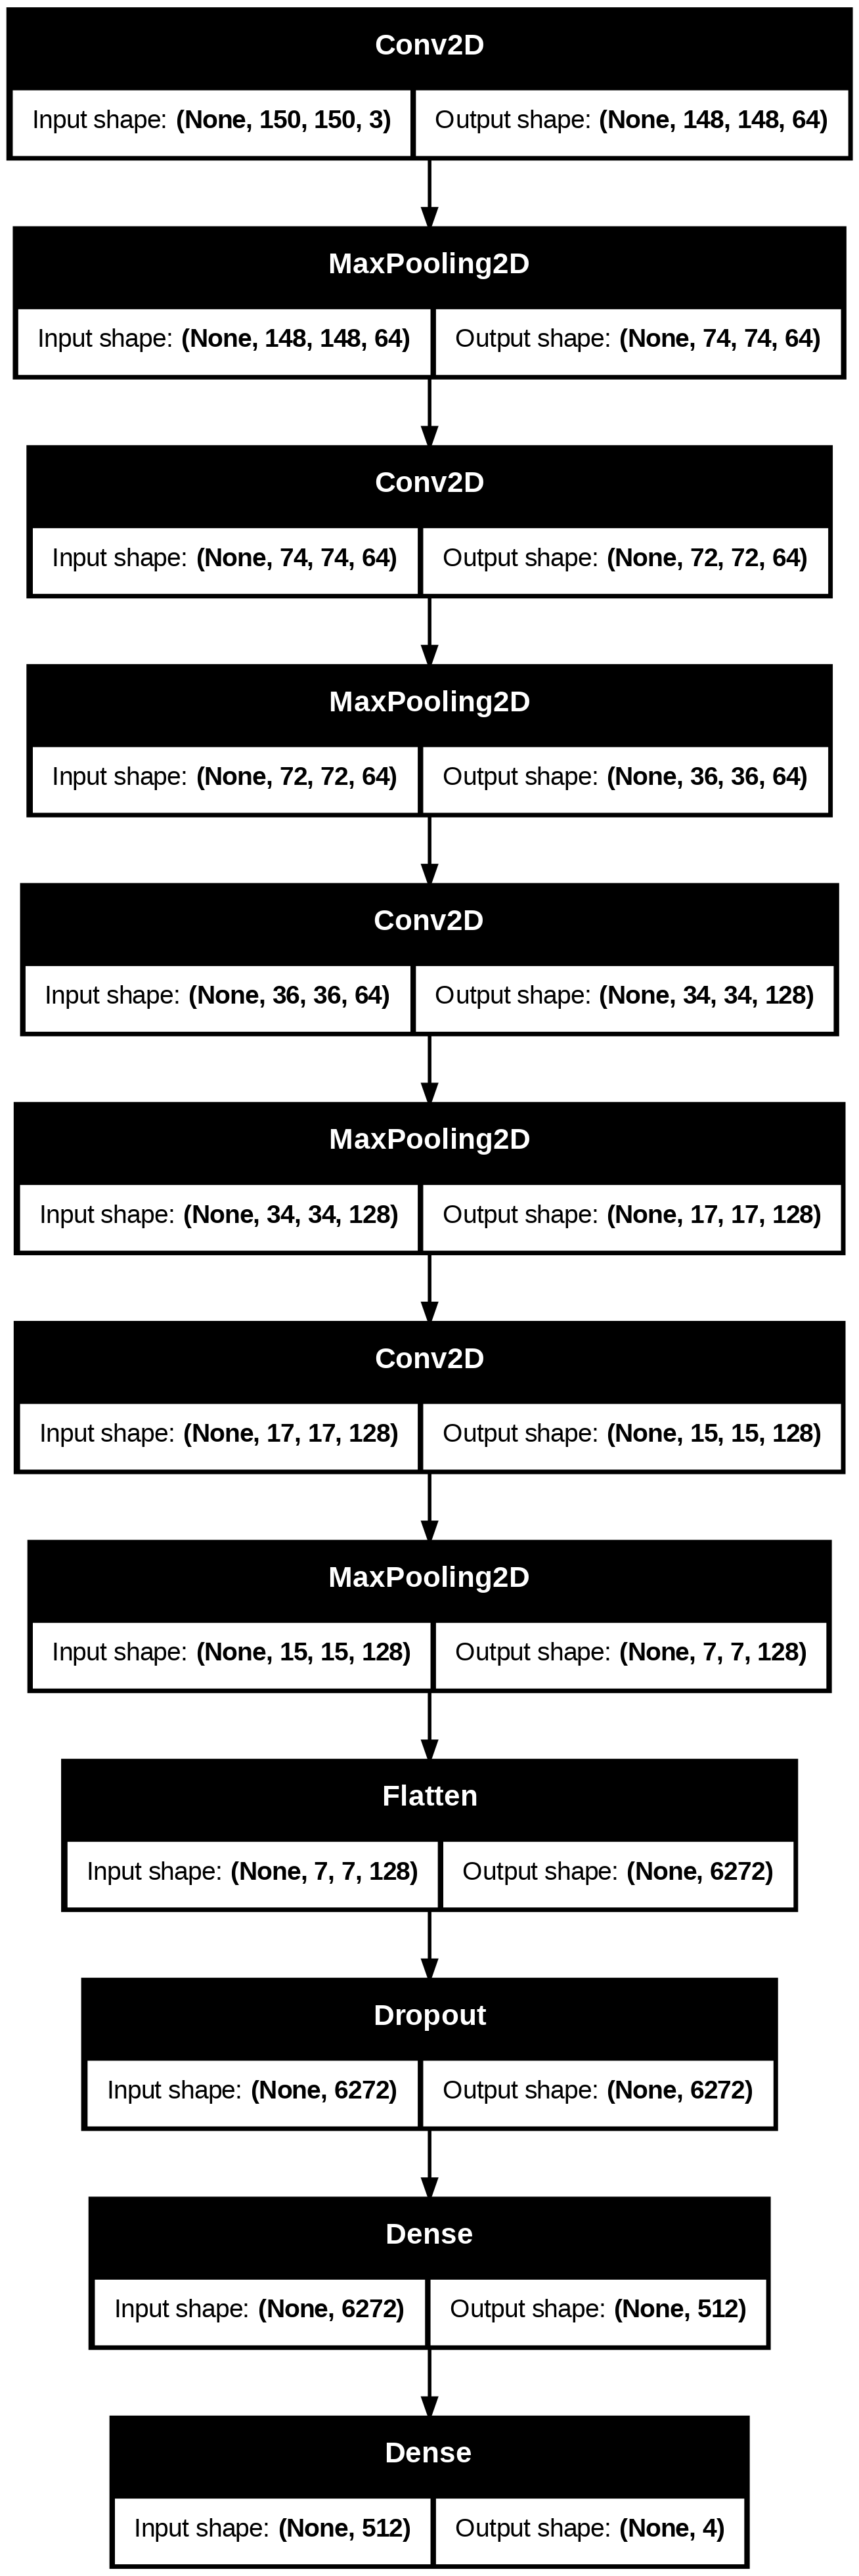

In [ ]:
plot_model(model,
           to_file="/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/simple_CNN.png",
           show_shapes=True)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn.keras", save_best_only=True)

history = model.fit(train_generator, epochs=50, steps_per_epoch=46,
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])



Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 625s 11s/step - accuracy: 0.3194 - loss: 1.3538 - val_accuracy: 0.2711 - val_loss: 1.2741
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 89s 570ms/step - accuracy: 0.3479 - loss: 1.2678 - val_accuracy: 0.3297 - val_loss: 1.2519
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 571ms/step - accuracy: 0.3549 - loss: 1.2514 - val_accuracy: 0.3407 - val_loss: 1.2467
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.3512 - loss: 1.2441 - val_accuracy: 0.2930 - val_loss: 1.3655
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 573ms/step - accuracy: 0.3579 - loss: 1.2385 - val_accuracy: 0.4982 - val_loss: 1.1800
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 573ms/step - accuracy: 0.4840 - loss: 1.1738 - val_accuracy: 0.5311 - val_loss: 1.1992
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 564ms/step - accuracy: 0.5434 - loss: 1.1178 - val_accuracy: 0.5311 - val_loss: 1.0621
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.5793 - loss: 1.0305 - val_accur

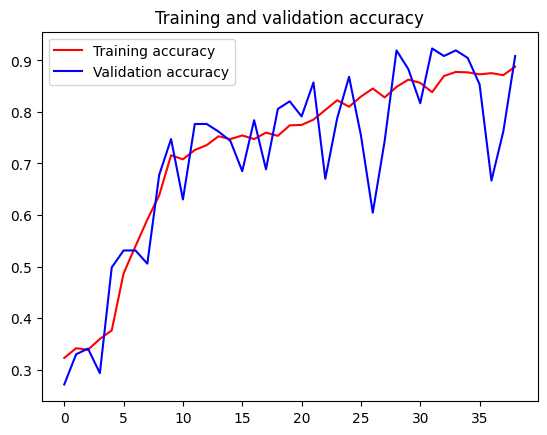

In [ ]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [ ]:
model = tf.keras.models.load_model("cnn.h5") # rollback to best model


In [ ]:
model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - accuracy: 0.8890 - loss: 0.2985


[0.2758299708366394, 0.9084249138832092]

In [ ]:
model.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.9003 - loss: 0.3077


[0.2797391712665558, 0.9051094651222229]

In [ ]:
# Save the Keras model in SavedModel (Protobuf) format
model.save(os.path.join("", "saved_model/my_model"), save_format="tf")

## Load model

In [ ]:
model_path = "/content/drive/MyDrive/CSIO Contents/DBT/plant pathology dataset/cnn.keras"

In [ ]:
loaded_model = load_model(model_path)

In [ ]:
loaded_model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - accuracy: 0.9462 - loss: 0.1851


[0.2562524676322937, 0.9194139242172241]

In [ ]:
loaded_model.evaluate(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - accuracy: 0.8728 - loss: 0.3450


[0.32002171874046326, 0.8832116723060608]

## Pretrained VGG

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [25]:
IMG_SIZE = 150

In [26]:
# Load the pre-trained VGG16 model (excluding the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [27]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [28]:
# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

In [29]:
# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,911,556 (72.14 MB)

 Trainable params: 4,196,868 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG16.keras", save_best_only=True)

history = model.fit(train_generator, epochs=2, steps_per_epoch=46,
                    validation_data = validation_generator, validation_steps=12, callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 751s 14s/step - accuracy: 0.3447 - loss: 2.6229 - val_accuracy: 0.5385 - val_loss: 1.1258
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 529s 11s/step - accuracy: 0.5443 - loss: 1.0682 - val_accuracy: 0.6154 - val_loss: 0.9971


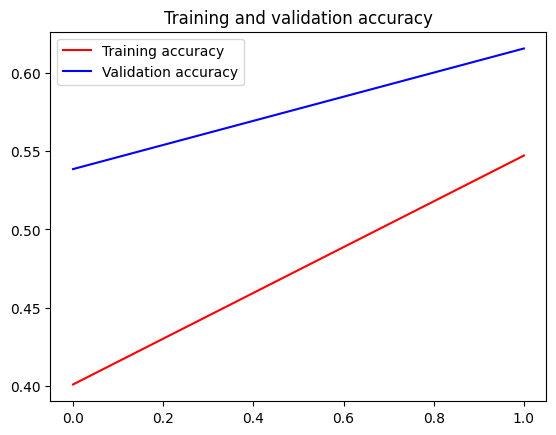

In [33]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()